# Event Study Methodologies - Difference in Differences

- Author: Mathis Mourey
- Date: 20/04/2024

In [1]:
# Some aesthetics options 
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define the Economist-style color palette
economist_colors = ['#E3120B', # Red
                    '#005689', # Blue
                    '#6B6E68', # Grey
                    '#FFB81C', # Yellow
                    '#8F253B', # Wine
                    '#AAAAB4'] # Light Grey

# Apply the style settings
plt.style.use('classic') # Use a classic style as the base

mpl.rcParams.update({
    # Use serif font similar to The Economist's
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    
    # Set the figure background and axes face color
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    
    # Set the color of the gridlines
    'grid.color': 'lightgrey',
    
    # Set titles and labels size
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    
    # Set the ticks parameters
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'xtick.color': 'black',
    'ytick.color': 'black',
    
    # Set the legend parameters
    'legend.frameon': False,
    'legend.fontsize': 12,
    
    # Set the lines parameters
    'lines.linewidth': 2,
    'lines.markersize': 6,
    
    # Set the plot edges and grid
    'axes.edgecolor': 'grey',
    'axes.grid': True,
    'grid.alpha': 0.5,
})

import warnings
warnings.filterwarnings("ignore")

## Background
*** 

Welcome back in this series of notebooks on event studies methodologies! This notebook focuses on the Difference-in-Differences (DiD) method. Let's get started! 

The DiD methodology is a statistical technique commonly used in econometrics and finance to estimate the causal effect of a specific treatment or intervention by comparing the changes in outcomes over time between a treatment group and a control group. This method is particularly valuable in observational studies where random assignment to groups is not possible.

DiD relies on a simple idea: comparing the difference in outcomes before and after an intervention for both the treatment group and the control group. By analyzing the differences in these differences, researchers can attempt to isolate the effect of the intervention from other confounding factors.

To start our study, we need: 
- **A Treatment Group**: This group is affected by the intervention (e.g., a company that undergoes a merger).- **A Control Group**: This group is not affected by the intervention but is similar in other respects to the treatment group (e.g., companies in the same industry that did not undergo a merger)
- **A Variable of interest**: This will be the variable through which we will study the impact of the event.
- **A 
Before and At*e**r: You need data from before and after the intervention for both groups.

The idea behind DiD is simple. We want to compare the average values of exposed firms/the exposed group before and after a specific event. However, just measuring the difference in the exposed group leaves the possibility that some other factor was at play too (not only the event). 

So the DiD methodology proposes the following solution: We find another group of firms (very similar to the one exposed to the event) but that was not exposed. This is actually the hardest part of the approach. Finding a control group that is very similar to the treatment group but wasn't impacted by the event is complex to say the least :) Once we find this group, we also compute the difference in averages between before and after the event. Finally, we just need to compare. *Is the difference in averages for the treatment group significantly different from the one for the control group?* 

## The approach in detail
*** 

### The simple case: DiD as a t-test

This is a first, simplistic case, just to understand the idea behind the DiD methodology. We start with the following information: 
- **Treatment Group (T)**: The group that experiences the intervention.
- **Control Group (C)**: The group that does not experience the intervention.
- **Before Period (Pre)**: Measurements before the intervention.
- **After Period (Post)**: Measurements after the intervention.

The aim of the method is to study whether a specific event impacted the **T** group. To do so, we look at the Difference in the variable of interest: 

$$\Delta T = \text{Mean}(T_{\text{Post}}) - \text{Mean}(T_{\text{Pre}})$$

Where $\Delta T$ is the difference in the means of the variable of interest between the period after and before the event. If the difference is significantly different from 0, then we could think that we identified an effect of the event. 

But there is a twist! What if something else was at play? What if the impact that we just measured comes from somewhere else than the event? To control for that effect, we will assess the same difference in means but in a group that wasn't exposed to the event: 

$$\Delta C = \text{Mean}(C_{\text{Post}}) - \text{Mean}(C_{\text{Pre}})$$

Where $\Delta C$ is the difference in the means of the variable of interest for the control group. Now, we just need to compare the differences in the two groups (hence *Difference-in-Differences*) to see if our event had an impact. 

And we run a t-test on the difference in the differences in treatment and control groups (hence the name: Difference-in-Differences). The hypotheses are: 
- $H_0: \Delta T - \Delta C = 0$ (No effect of the event)
- $H_1: \Delta T - \Delta C \neq 0$(There is an effect of the event)

The t-statistic is calculated as follows:
$$t = \frac{\mu_{\Delta T} - \mu_{\Delta C} }{\sqrt{s^2(n_T^{-1}+n_C^{-1})}}$$

Where $\mu_{\Delta T}$ and $\mu_{\Delta C}$ are the average changes in the treatment and control groups. $s^2$ is the pooled standard error of the two groups and $n_T$ and $n_C$ are the sample size for the treatment and control groups.

You compare the calculated t-statistic against a critical t-value from the t-distribution (depending on your chosen level of significance and degrees of freedom). If the absolute value of the t-statistic is greater than the critical value, you reject the null hypothesis, suggesting that the intervention had a statistically significant effect.

If the null hypothesis is rejected, it suggests a significant effect of the intervention. However, interpreting the direction and magnitude of the effect requires careful consideration of the data and context. Remember, statistical significance does not always imply practical significance.

This approach provides a statistical framework to determine the causal impact of an intervention using observational data, integrating the principles of hypothesis testing with economic models to inform decisions in finance and beyond.

### DiD as a t-test: A quick walkthrough

Let's assume that the regulatory change affects only half of the companies (treatment group), while the rest are unaffected (control group). We gather (create here for our purposes) the necessary data. We suppose that some companies are exposed to the apparition of a new regulation and would like to observe this effect on their stock price. 

Important side note! *Please note that the stock price is rarely the right variable of interest given the fact that it is influenced by a lot of factors. We use here the stock price out of simplicity. Historically, the preferred variable used in financial studies is the abnormal returns (You can find more info about this in the **EventStudy_PracticalExamples** notebook)*

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind

I'm hiding this part for educational purposes but if you would like to take a closer look at creating an educational synthetic dataset, look behind the curtain! :)

In [3]:
# Code to create the dataset

# Seed for reproducibility
np.random.seed(42)

# Parameters
n_days = 20
n_companies = 100
effect_size = 5  # Effect of the intervention

# Generating synthetic data
dates = pd.date_range(start='2023-01-01', periods=n_days*2, freq='D')
data = {
    'Company': np.tile(np.arange(n_companies), n_days*2),
    'Price': np.random.normal(loc=100, scale=10, size=n_companies*n_days*2),
    'Time': np.repeat(dates, n_companies)
}

df = pd.DataFrame(data)
df['Treatment'] = (df['Company'] < n_companies / 3).astype(int)
df['Post'] = (df['Time'] >= '2023-01-21').astype(int)
df['Treatment_Post'] = df['Treatment'] * df['Post']

# Introduce a synthetic effect for the treatment group post-treatment
df.loc[df['Treatment_Post'] == 1, 'Price'] -= effect_size
df = df.drop('Treatment_Post', axis=1)

So here's our dataset:
We have 100 companies and 33 of them were exposed to a new regulation. The dummy variable ```Treatment``` gives 1 if the firm was exposed to the event and 0 else. The dummy variable ```Post``` gives 0 if the data is recorded before this event and 1 after the event. 

The focus is to see how the regulation impacted exposed firms (we do not make any assumptions regarding whether the effect was positive/negative). So we will compare the change in averages (after - before event) between the control (non-exposed) and the treatment (exposed) groups. 

In [4]:
df.head()

,Company,Price,Time,Treatment,Post
0,0,104.967142,2023-01-01,1,0
1,1,98.617357,2023-01-01,1,0
2,2,106.476885,2023-01-01,1,0
3,3,115.230299,2023-01-01,1,0
4,4,97.658466,2023-01-01,1,0


We will first get the averages of the treatment and control groups both before and after the event. Technically, we are computing: 
$$\text{Mean}(T_{\text{Post}}), \: \text{Mean}(T_{\text{Pre}}), \: \text{Mean}(C_{\text{Post}}), \: \text{Mean}(C_{\text{Pre}})$$


In [5]:
treatment_means_pre = df[(df['Treatment'] == 1)].groupby(['Post', 'Company']).mean()['Price'].loc[0]
treatment_means_post = df[(df['Treatment'] == 1)].groupby(['Post', 'Company']).mean()['Price'].loc[1]

control_means_pre = df[(df['Treatment'] == 0)].groupby(['Post', 'Company']).mean()['Price'].loc[0]
control_means_post = df[(df['Treatment'] == 0)].groupby(['Post', 'Company']).mean()['Price'].loc[1]

Once we computed these, we will compute the changes for each groups between before and after the apparition of the new regulation:
$$\Delta T = \text{Mean}(T_{\text{Post}}) - \text{Mean}(T_{\text{Pre}})$$

$$\Delta C = \text{Mean}(C_{\text{Post}}) - \text{Mean}(C_{\text{Pre}})$$

In [6]:
diff_treatment = treatment_means_post - treatment_means_pre 
diff_control = control_means_post - control_means_pre

For the sake of clarity, ```diff_treatement``` is a vector of all the differences between the average price before and the average price after the regulation came into effect, for the treatment group.

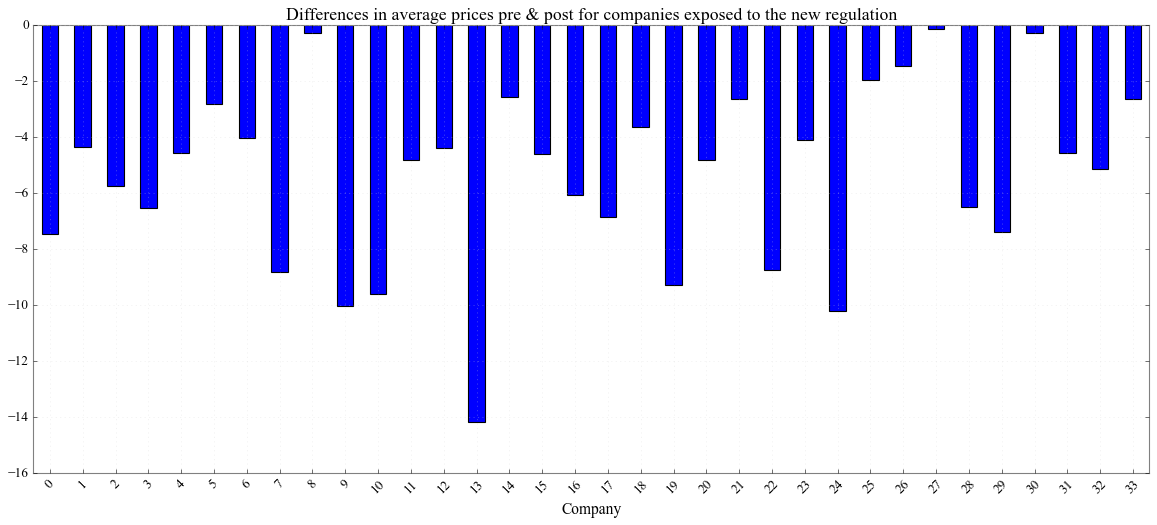

In [7]:
plt.figure(figsize=(18,7))
diff_treatment.plot.bar()
plt.xticks(rotation=45)
plt.title('Differences in average prices pre & post for companies exposed to the new regulation')
plt.show()

We can see that, for most of the firm, the apparition of the new regulation is associated with a decrease of stock price. We need to compare this group, with the control group to accept whether that decrease is caused by the new regulation.

In [8]:
print('The average difference in stock price for the exposed companies is: ' + str(diff_treatment.mean()))
print('The average difference in stock price for the non-exposed companies is: ' + str(diff_control.mean()))

The average difference in stock price for the exposed companies is: -5.333668228826704
The average difference in stock price for the non-exposed companies is: -0.6088170965304069


In [9]:
print('The difference in the average differences (DiD) is: ' + str(diff_treatment.mean()-diff_control.mean()))

The difference in the average differences (DiD) is: -4.724851132296297


Here, we can already see that the groups of companies that were affected by the regulation saw their stock price decrease when the control group didn't see much of a change. Let's get the DiD estimator and see if this difference is significative. 

Now computing for the significance: 

In [10]:
t_stat, p_value = ttest_ind(diff_treatment, diff_control, equal_var=False)

print('The t-statistic is: '+ str(t_stat))
print('The p-value is: ' + str(p_value))

The t-statistic is: -6.975846849061687
The p-value is: 1.6826942676416391e-09


The t-statistic is huge, hence the p-value is very small. We can reject the null hypothesis and concludes that the new regulation seem to have pushed the stock price of the companies concerned down.

As usual, let's try to see this effect visually:

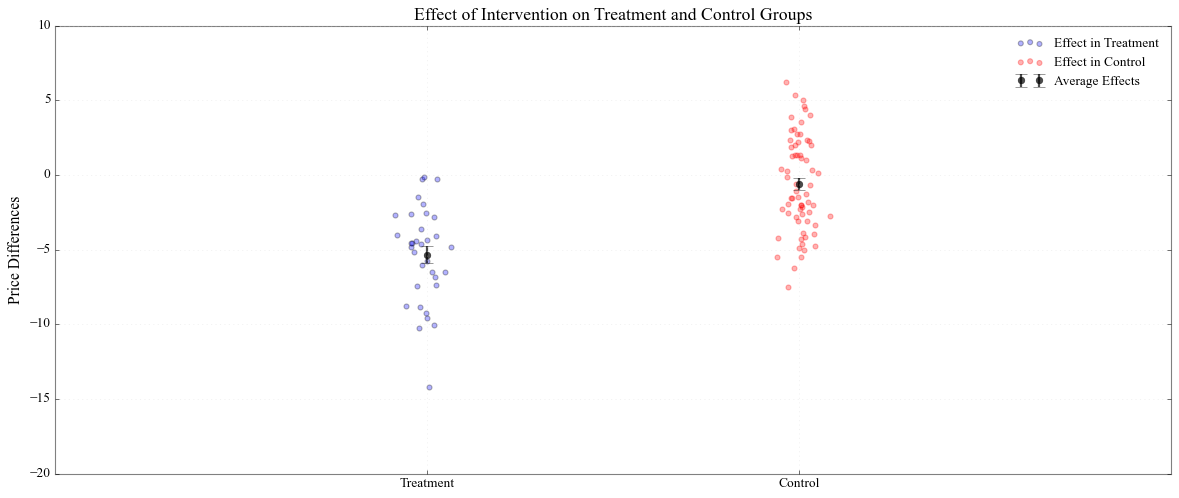

In [11]:
# Create plot
plt.figure(figsize=(18,7))
plt.errorbar(["Treatment", "Control"],
        [diff_treatment.mean(), diff_control.mean()],
        yerr=[diff_treatment.sem(), diff_control.sem()], capsize=5, label='Average Effects', alpha=0.7, fmt='o', color='black')
plt.scatter([0+np.random.normal(0,0.03) for i in range(len(diff_treatment))], diff_treatment, alpha=0.3, label='Effect in Treatment')
plt.scatter([1+np.random.normal(0,0.03) for i in range(len(diff_control))], diff_control, alpha=0.3, color='red', label='Effect in Control')

# Label and settings
plt.xlim([-1,2])
plt.xticks([0, 1], ['Treatment', 'Control'])
plt.ylabel('Price Differences')
plt.title('Effect of Intervention on Treatment and Control Groups')
plt.legend()
plt.show()

### The more realistic case: DiD as a linear regression 

The Difference in Differences (DiD) methodology can also be interpreted through the lens of regression analysis, which offers a more flexible and robust statistical framework for handling various complexities such as multiple control variables and different types of data structures. Here’s how you can conceptualize and implement DiD using regression analysis:

In a regression framework, DiD analysis can be represented as a linear regression model where the outcome variable is regressed on indicators for the treatment status, time periods, and their interaction. The interaction term is key, as it provides the DiD estimate, capturing the causal effect of the intervention.

Essentially, the final outcome of the test is the same as in the t-test setup. However, using a linear regression allows us to use control variables or to be in general more flexible about our approach. However, using a linear regression comes with a bunch of assumptions and things we should pay attention to :) (Look at the **BaseMethods_LinearRegression** notebook for more details!)

The basic regression model for a two-period DiD analysis can be specified as follows:

$$ Y_{it} = \beta_0 + \beta_1 \text{Treatment}_i + \beta_2 \text{Post}_t + \beta_3 (\text{Treatment}_i \times \text{Post}_t) + \epsilon_{it} $$

Where:
- $Y_{it}$ is the outcome variable for company $i$ at time  $t$.
- $\text{Treatment}_i$ is a dummy variable that equals 1 if the company $i$ belongs to the treatment group, and 0 if it belongs to the control group.
- $\text{Post}_t$ is a dummy variable that equals 1 if the observation is in the post-treatment period, and 0 if in the pre-treatment period.
- $\text{Treatment}_i \times \text{Post}_t$ is the interaction term between the treatment and post variables.
- $\beta_0$ is the constant term, $\beta_1$, $\beta_2$, and $\beta_3$ are the coefficients to be estimated, and $\epsilon_{it}$ is the error term.

$\beta_0$ gives you the average for the control group in the period before the event. Think of it as the following. If we follow a control group company then $\text{Treatment}_i = 0$; if we are before the event then $\text{Post}_t = 0$; and it follows that $(\text{Treatment}_i \times \text{Post}_t) = 0$. So most of the equation becomes null and $\beta_0$ remains! 

Following a similar logic, $\beta_1$ gives you how much more (if positive) or less (if negative) the treatment group has, in average, compared to the control group.

$\beta_2$ gives you the difference in the averages of the control group before and after the event. 

The actual coefficient of interest in this model is $\beta_3$, which estimates the DiD. It represents the average effect of the intervention on the outcome variable, net of baseline differences between the treatment and control groups; and general time trends that affect all companies. Simply put, the coefficient $\beta_3$ provides a measure of how the treatment influenced the outcome variable, controlling for other factors. A positive $\beta_3$ indicates a positive effect of the treatment, while a negative $\beta_3$ suggests a negative effect. The magnitude of $\beta_3$ indicates the size of the effect.

A quick visual to clarify things :)

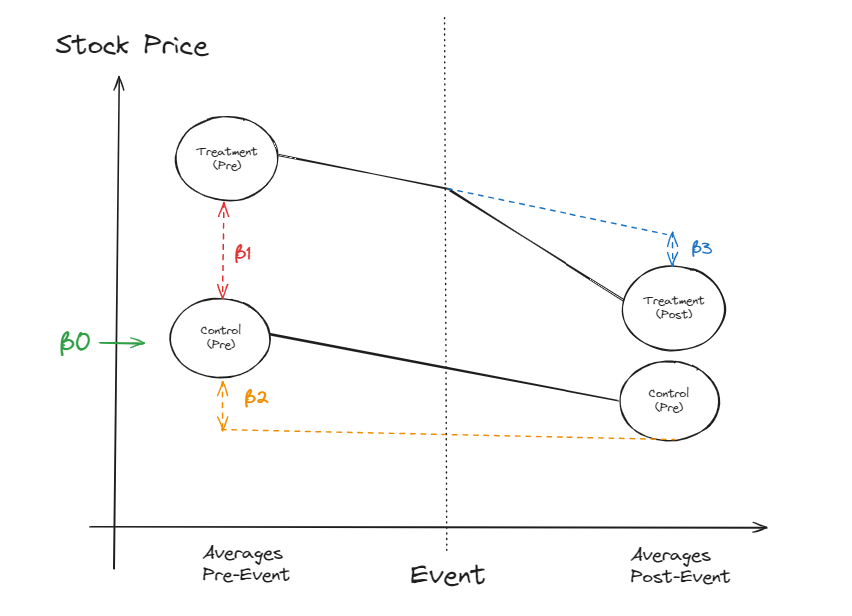

### DiD as a regression: A (very) quick walkthrough

Let's study the same case as the one above (it will be easier to compare the results in that way :) ). 

Just as a reminder: We have 100 firms in total, 33 have been exposed to a regulation that took place on 2023-01-20, the rest serve as the control group. 

**An important note**: Most often financial markets react to the announcement rather than the effective date of effect. Financial analysts/traders know whether the new regulation is good/bad news and change their strategies when the announcement of the regulation is made. In that sense, in most financial studies, the event date is the date of the announcement. 

Let's start with a plot to see if the effect is actually visible to the naked eye :)

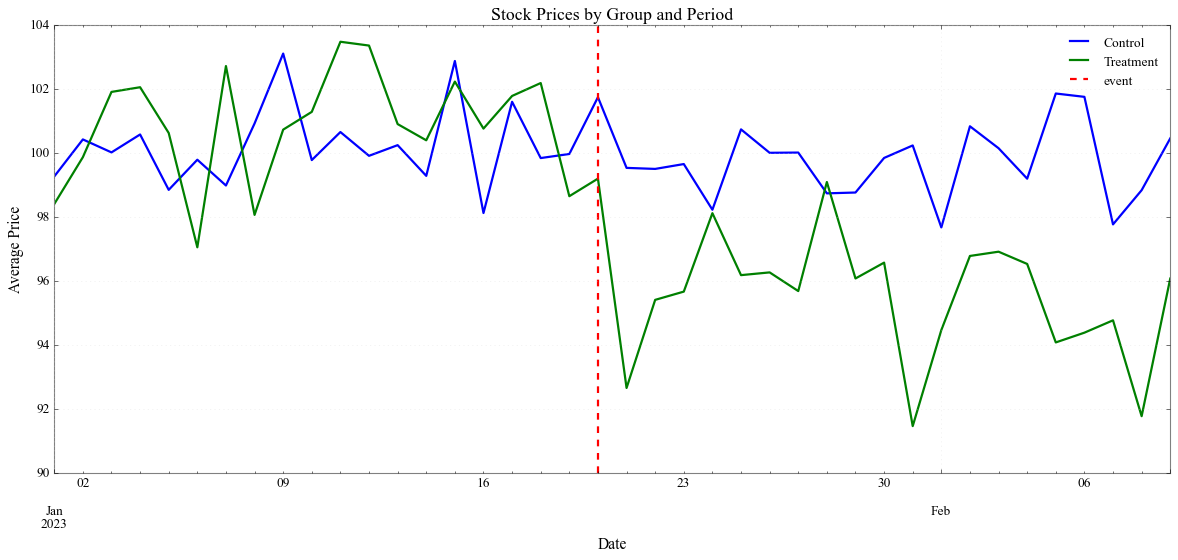

In [12]:
# Make plot 
plt.figure(figsize=(18,7))
for key, group in df.groupby(['Treatment']):
    label = f"{'Treatment' if key[0] == 1 else 'Control'}"
    group.groupby('Time')['Price'].mean().plot(label=label)
plt.axvline(x=pd.to_datetime('2023-01-20'), color='red', linestyle='--', label='event')
plt.title('Stock Prices by Group and Period')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.legend(loc='best')
plt.grid(True)
plt.show()

We don't need to be world-renowned econometricians to see that there seems to be an effect. The control group (in blue) follows a trend that seems undisturbed by the event. On the other side, the treatment group (in green) has a clear drop in prices right after the event. 

But it wouldn't be serious to just accept that there is an effect. The proper approach is to apply the methodology and use statistics to validate the magnitude and significance of the effect. 

So let's propose the following model: 

$$ S_{it} = \beta_0 + \beta_1 \text{Exposed to Regulation}_i + \beta_2 \text{Post}_t + \beta_3 (\text{Exposed to Regulation}_i \times \text{Post}_t) + \epsilon_{it} $$

Where $S_{it}$ is the stock price of firm $i$ at time $t$. And $\text{Exposed to Regulation}_i$ is the dummy variable that gives $1$ if firm $i$ has been exposed to the new regulation and $0$ otherwise. The rest is the same as in the presentation of the methodology above.

Let's use the ```statsmodels``` package to run our regression and get our results:

In [13]:
model = ols('Price ~ C(Treatment) + C(Post) + C(Treatment):C(Post)', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     43.89
Date:                Tue, 23 Apr 2024   Prob (F-statistic):           6.69e-28
Time:                        07:24:14   Log-Likelihood:                -14871.
No. Observations:                4000   AIC:                         2.975e+04
Df Residuals:                    3996   BIC:                         2.978e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                        100.2861      0.274    365.550      0.000      99.748     100.824
C(Treatment)[T.1]                  0.4846      0.470      1.030      0.303      -0.438       1.407
C(Post)[T.1]                      -0.6088      0.388     -1.569      0.117      -1.369       0.152
C(Treatment)[T.1]:C(Post)[T.1]    -4.7249      0.665     -7.101      0.000      -6.029      -3.420
==============================================================================
Omnibus:                        0.528   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.768   Jarque-Bera (JB):                0.521
Skew:                           0.028   Prob(JB):                        0.771
Kurtosis:                       3.001   Cond. No.                         6.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Let's interpret our coefficients :)
***

Starting with **$\beta_0$ as the average of the control group before the event**! 

In [14]:
# Expend to see details
print('B0 in the regression model: ' +str(model.params['Intercept']))
print('Average in control before the event: ' + str(control_means_pre.mean()))

B0 in the regression model: 100.28608379916452
Average in control before the event: 100.28608379916363


As we can see, we need to get into a lot of decimals before we see a difference occurring.
***

About **$\beta_1$ as the excess/deficit of the treatment group compared to the control group before the event**. 

In [15]:
# Expend to see details 
excess_treatment_vs_control = treatment_means_pre.mean() - control_means_pre.mean()

print('B1 in the regression model: ' +str(model.params['C(Treatment)[T.1]']))
print('Excess of treatment group compared to control (before the event): ' + str(excess_treatment_vs_control ))

B1 in the regression model: 0.48458137115814154
Excess of treatment group compared to control (before the event): 0.48458137115819966


***
**$\beta_2$ as the difference in the averages of the control group before and after the event.**

In [16]:
# Expend to see details
print('B2 in the regression model: ' +str(model.params['C(Post)[T.1]']))
print('Excess of the control group after the event: ' + str((control_means_post.mean()) - control_means_pre.mean()))


B2 in the regression model: -0.6088170965315243
Excess of the control group after the event: -0.60881709653043


***
And finally, **$\beta_3$ as the estimated impact of the event (DiD effect)  :)**

In [17]:
# Expend to see details
did_coefficient = model.params['C(Treatment)[T.1]:C(Post)[T.1]']
print("DiD Estimate in the regression: " + str(did_coefficient))
print('Did Estimate as computed in the previous sections: ' + str(diff_treatment.mean()-diff_control.mean()))

DiD Estimate in the regression: -4.7248511322964175
Did Estimate as computed in the previous sections: -4.724851132296297


We can see that the effect of the DiD is the same whether we use the t-test or the regression approach. It's normal! Using categorical variables in regression can translate to using t-tests. So why is the regression a better approach? It's because of the alternatives and possibilities it provides. We could easily add control variables and other types of effect and heteroskedasticity adjustments in the regression that would be much harder to implement in the t-test setting. 

### But DiD doesn't work all of the time no?

DiD only estimates the differences in averages. This is a simple and straightforward approach. It is usually used because it gives interpretable results. But indeed, if the effect is a bit more complex than a change of average then other methods can be useful. Also, what to do if the event impacts only 1 firm? 

Sometimes, an event will generate a strong effect on the day of the announcement but then will lead to a correction the next day. This will make the difference in averages not significance despite the actual effect of the event. 

There are also so many considerations to take into account: what happens if the control and treatment groups are heavily unbalanced? How many days should we consider before and after the event? These are all valid questions :) And the answer is not pleasant: it mostly depends on the specific situation. All studies are unique and researching is mostly about arbitraging between biases/limitations. 